<a href="https://colab.research.google.com/github/Dash400air/SRWS_PSG/blob/main/SRWS_PSG-Threshold_pred_v2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GPU check

In [1]:
!nvidia-smi

Tue Aug 17 05:18:17 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 470.57.02    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   38C    P0    28W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# Setup

In [2]:
!pip install transformers==4.5.0 pytorch-lightning==1.2.7

     |████████████████████████████████| 2.1 MB 8.8 MB/s 
     |████████████████████████████████| 830 kB 48.4 MB/s 
     |████████████████████████████████| 895 kB 59.6 MB/s 
     |████████████████████████████████| 3.3 MB 40.8 MB/s 
     |████████████████████████████████| 269 kB 69.2 MB/s 
     |████████████████████████████████| 118 kB 66.2 MB/s 
     |████████████████████████████████| 272 kB 79.8 MB/s 
     |████████████████████████████████| 829 kB 59.4 MB/s 
     |████████████████████████████████| 1.3 MB 47.3 MB/s 
     |████████████████████████████████| 294 kB 74.0 MB/s 
     |████████████████████████████████| 142 kB 75.3 MB/s 
  Created wheel for future: filename=future-0.18.2-py3-none-any.whl size=491070 sha256=465baf391482cd18235d291af6b4d243a8d95d9b1eabd00479800e76cb771707
  Stored in directory: /root/.cache/pip/wheels/56/b0/fe/4410d17b32f1f0c3cf54cdfb2bc04d7b4b8f4ae377e2229ba0
  Created wheel for PyYAML: filename=PyYAML-5.3.1-cp37-cp37m-linux_x86_64.whl size=44635 sha256=c49c85a0

In [3]:
import os
import random
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import RobertaTokenizer, RobertaForSequenceClassification
import pytorch_lightning as pl

from sklearn.metrics import fbeta_score
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LinearRegression

import seaborn as sns

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
train = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/SRWS-PSG/train (2).csv')
test = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/data/SRWS-PSG/test (1).csv')

# Data

In [6]:
train.head()

,id,title,abstract,judgement
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0


In [7]:
train.describe()

,id,judgement
count,27145.000000,27145.000000
mean,13572.000000,0.023282
std,7836.230865,0.150802
min,0.000000,0.000000
25%,6786.000000,0.000000
50%,13572.000000,0.000000
75%,20358.000000,0.000000
max,27144.000000,1.000000


In [8]:
test.head()

,id,title,abstract
0,27145,Estimating the potential effects of COVID-19 p...,The objective of the paper is to analyse chang...
1,27146,Leukoerythroblastic reaction in a patient with...,NaN
2,27147,[15O]-water PET and intraoperative brain mappi...,[15O]-water PET was performed on 12 patients w...
3,27148,Adaptive image segmentation for robust measure...,We present a method that significantly improve...
4,27149,Comparison of Epidemiological Variations in CO...,The objective of this study is to compare the ...


In [9]:
#train = train.drop(index=range(250,27145))

In [10]:
train.tail()

,id,title,abstract,judgement
27140,27140,The amyloidogenic pathway of amyloid precursor...,Amyloid beta-protein (A beta) is the main cons...,0
27141,27141,Technologic developments in radiotherapy and s...,We present a review of current technological p...,0
27142,27142,Novel screening cascade identifies MKK4 as key...,Phosphorylation of Tau at serine 422 promotes ...,0
27143,27143,Visualization of the gall bladder on F-18 FDOP...,The ability to label dihydroxyphenylalanine (D...,0
27144,27144,Multidetector CT findings and differential dia...,OBJECTIVE: To compare the multidetector CT (MD...,0


# Config

In [11]:
class Config:
    def __init__(self):
        self.model = 'bert-base-uncased'
        self.tokenizer = BertTokenizer.from_pretrained(self.model)
        self.title_max = 134
        self.abstract_max = 3302
        self.seed = 471

Config = Config()

Downloading:   0%|          | 0.00/232k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/466k [00:00<?, ?B/s]

# Seed

In [12]:
def seed_torch(seed=42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True

seed_torch(Config.seed)

# Kfold

In [13]:
def get_train_data(train):
    Fold = StratifiedKFold(n_splits=5, shuffle=True, random_state=Config.seed)
    for n, (train_index, val_index) in enumerate(Fold.split(train, train["judgement"])):
        train.loc[val_index, "fold"] = int(n)
    train["fold"] = train["fold"].astype(np.uint8)

    return train

train = get_train_data(train)

In [14]:
train.head()

,id,title,abstract,judgement,fold
0,0,One-year age changes in MRI brain volumes in o...,Longitudinal studies indicate that declines in...,0,0
1,1,Supportive CSF biomarker evidence to enhance t...,The present study was undertaken to validate t...,0,1
2,2,Occurrence of basal ganglia germ cell tumors w...,Objective: To report a case series in which ba...,0,4
3,3,New developments in diagnosis and therapy of C...,The etiology and pathogenesis of idiopathic ch...,0,3
4,4,Prolonged shedding of SARS-CoV-2 in an elderly...,NaN,0,1


# Dataset

In [15]:
class BaseDataset(Dataset):
    def __init__(self, df, include_labels=True):
        tokenizer = Config.tokenizer

        self.df = df
        self.include_labels = include_labels

        self.title = df["title"].tolist()
        self.encoded = tokenizer(
            self.title,
            return_tensors='pt',
            max_length = Config.title_max,
            padding = 'max_length', 
            truncation = True,
            return_attention_mask=True
        )
        
        if self.include_labels:
            self.labels = df["judgement"].values

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        input_ids = self.encoded['input_ids'][idx]
        attention_mask = self.encoded['attention_mask'][idx]
        output = {'input_ids': input_ids, 'attention_mask': attention_mask}

        if self.include_labels:
            label = torch.tensor(self.labels[idx]).float()
            output_l = {'input_ids': input_ids, 'attention_mask': attention_mask, 'labels': label}
            return output_l

        return output

# Model

In [16]:
class SequenceClassification_pl(pl.LightningModule):

  def __init__(self, model_name, num_labels, lr):
    # model_name: Transformersのモデル名
    # num_labels: ラベルの数
    # lr: 学習率

    super().__init__()

    self.save_hyperparameters()
    
    self.bert_sc = BertForSequenceClassification.from_pretrained(
        model_name,
        num_labels=num_labels
    )

  def training_step(self, batch, batch_idx):
    output = self.bert_sc(**batch)
    loss = output.loss
    self.log('train_loss', loss)
    return loss

  def validation_step(self, batch, batch_idx):
    output = self.bert_sc(**batch)
    val_loss = output.loss
    self.log('val_loss', val_loss)

  def test_step(self, batch, batch_idx):
    labels = batch.pop('labels').detach().cpu().numpy() #labelsについて，GPU上のTensorではfbeta_scoreが受け付けてくれないため，CPUに移動させ，Numpyに変換
    output = self.bert_sc(**batch)
    labels_predicted = output.logits.detach().cpu().numpy().argmax(-1)  #同上
    fbeta = fbeta_score(labels, labels_predicted, beta=7)
    self.log('fbeta_score', fbeta)
  
  def configure_optimizers(self):
    return torch.optim.AdamW(self.parameters(), lr=self.hparams.lr)

# Dataloader

In [17]:
valid = 0
test = 1

trn_idx = train[train["fold"] > test].index
val_idx = train[train["fold"] == valid].index
test_idx = train[train["fold"] == test].index

train_folds = train.loc[trn_idx].reset_index(drop=True)
valid_folds = train.loc[val_idx].reset_index(drop=True)
test_folds = train.loc[test_idx].reset_index(drop=True)

train_dataset = BaseDataset(train_folds)
valid_dataset = BaseDataset(valid_folds)
test_dataset = BaseDataset(test_folds, include_labels=False)


train_loader = DataLoader(
        train_dataset,
        batch_size=32,
        shuffle=True,
        drop_last=True,
    )

valid_loader = DataLoader(
        valid_dataset,
        batch_size=16,
        shuffle=False,
    )

test_loader = DataLoader(
        test_dataset,
        batch_size=16,
        shuffle=False,
        pin_memory=True
)

# Train

In [18]:
checkpoint = pl.callbacks.ModelCheckpoint(
    monitor='val_loss',
    mode='min',
    save_top_k=1,
    save_weights_only=True,
    dirpath='model/',
)

trainer = pl.Trainer(
    gpus=1,
    max_epochs=3,
    callbacks = [checkpoint]
)

GPU available: True, used: True
TPU available: False, using: 0 TPU cores


In [19]:
model = SequenceClassification_pl(
    Config.model, num_labels=1, lr=1e-5)

Downloading:   0%|          | 0.00/570 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [20]:
trainer.fit(model, train_loader, valid_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type                          | Params
----------------------------------------------------------
0 | bert_sc | BertForSequenceClassification | 109 M 
----------------------------------------------------------
109 M     Trainable params
0         Non-trainable params
109 M     Total params
437.932   Total estimated model params size (MB)


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

1

# Predict

In [21]:
best_model = checkpoint.best_model_path
predict_model = SequenceClassification_pl.load_from_checkpoint(best_model)
bert_sc = predict_model.bert_sc.cuda()

Some weights of the model checkpoint at bert-base-uncased were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.decoder.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at

In [22]:
def get_scores(model, test_loader):
    model.eval()

    logits = []
    for i, data in enumerate(test_loader):
        input_ids = data["input_ids"].cuda()
        attention_mask = data["attention_mask"].cuda()
        with torch.no_grad():
            output = model(input_ids, attention_mask)
        logit = output.logits
        logits.append(logit)
    
    softmax = nn.Softmax(dim=0)
    scores = []
    for i in range(len(logits)):
      x = softmax(logits[i]).detach().cpu().tolist()
      for v in x:
        scores.append(v)
    return scores

In [25]:
scores = get_scores(bert_sc, test_loader)

# Get Threshold

In [26]:
score_df = pd.DataFrame(scores)
score_df = score_df.rename(columns={0: 'score'})

In [27]:
score = pd.concat([score_df, test_folds['judgement']], axis=1)

In [28]:
score.head()

,score,judgement
0,0.060443,0
1,0.061405,0
2,0.061577,0
3,0.060931,0
4,0.061468,0


In [29]:
X = score['judgement']
y = score['score']

In [30]:
clf = LinearRegression()
clf.fit(X.values.reshape(-1, 1), y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [31]:
target = [1]
threshold = clf.predict(pd.DataFrame(target))
print(f'Threshold: {threshold[0]}')

Threshold: 0.08505248452817636


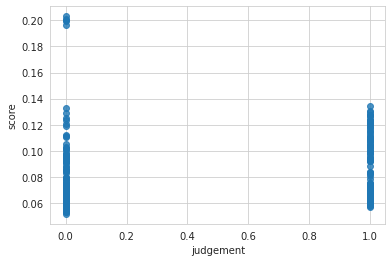

In [32]:
sns.set_style("whitegrid")
sns.regplot(x="judgement", y="score", data=score, fit_reg=False)